# Clasificacion de Noticias en "Verdaderas" o "Falsas"


**CAIRO Lucia** **13030**

La creciente propagación de noticias falsas representa un riesgo social, y verificarlas manualmente resulta ineficiente. Este proyecto busca automatizar este proceso mediante un clasificador que detecte patrones en el texto para determinar si una noticia es real o falsa.

#### Descripción del Dataset

Se utilizará el dataset Fake News Detection disponible en Kaggle, que contiene artículos etiquetados como Fake o Real. El conjunto de datos incluye las siguientes columnas principales:
- Title: El título de la noticia.
- Text: El contenido completo de la noticia.
- Label: La etiqueta binaria (Fake o Real).

Dataset disponible en: https://www.kaggle.com/code/therealsampat/fake-news-detection/notebook

#### Objetivo del Análisis

Diseñar e implementar un modelo de aprendizaje supervisado para identificar si una noticia es falsa o verdadera.

#### Algoritmos a implementar:

- Regresión Logística
- Naive Bayes
- KNN
- Transformers

#### Indice:

1. **Importar las bibliotecas necesarias**
2. **Cargar el dataset**
3. **Explorar y limpiar los datos**
4. **Preparar los datos**
5. **Dividir los datos**
6. **Modelos**
    
    6.1. **Regresión Logística (Método bag-of-words)**

    6.2. **Naive Bayes (Método bag-of-words)**
    
    6.3. **KNN (Método bag-of-words)**
    
    6.4. **Transformers**
7. **Comparaciones**
8. **Concluciones**

### 1. Importar las bibliotecas necesarias

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import keras
from keras import ops
from keras import layers
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

### 2. Cargar el dataset



In [ ]:
df_fake = pd.read_csv("./Fake.csv")
df_true = pd.read_csv("./True.csv")

In [ ]:
df_fake.head()
df_fake.info()
df_fake.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [ ]:
df_true.head()
df_true.info()
df_true.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


Ahora vamos a unir ambos conjuntos de datos para trabajar con uno único, lo que reduce la posibilidad de errores durante el análisis. Ademas para aplicar los mismos pasos de limpieza y transformación a todas las noticias, independientemente de su categoría.

In [ ]:
df_fake = df_fake[['title', 'text']]
df_true = df_true[['title', 'text']] # columnas que nos interesan

# Agregar una columna 'label' para identificar la clase
df_fake['label'] = 'fake'
df_true['label'] = 'true'

# Combinar los datasets
df = pd.concat([df_fake, df_true], ignore_index=True)

# Mezclar las filas aleatoriamente para evitar sesgos de orden
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Ver la estructura del nuevo dataset
print(df.info())
print(df['label'].value_counts())
df.head()

<ipython-input-32-9157edfc2806>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake['label'] = 'fake'
<ipython-input-32-9157edfc2806>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true['label'] = 'true'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
None
label
fake    23481
true    21417
Name: count, dtype: int64


,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",fake
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,true
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,true
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",fake
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",true


### 3. Explorar y limpiar los datos

Vamos a eliminar los datos duplicados

In [ ]:
def count_unique_and_duplicates_by_text(df, text_column='text'):
    total = len(df)
    unique = df[~df.duplicated(subset=[text_column])].shape[0]
    duplicates = total - unique
    return {'total': total, 'unique': unique, 'duplicates': duplicates}

counts = count_unique_and_duplicates_by_text(df, text_column='text')
print(f"Total: {counts['total']}, Únicos: {counts['unique']}, Duplicados: {counts['duplicates']}")

Total: 44898, Únicos: 38646, Duplicados: 6252


In [ ]:
def remove_text_duplicates(df, text_column='text'):
    total_before = len(df)
    df_cleaned = df.drop_duplicates(subset=[text_column], keep='first')
    total_after = len(df_cleaned)
    removed = total_before - total_after
    return df_cleaned, removed

df_cleaned, removed = remove_text_duplicates(df, text_column='text')
print(f"Cantidad de filas después de eliminar duplicadoa: {len(df_cleaned)}. Filas eliminadas: {removed}.")

Cantidad de filas después de eliminar duplicadoa: 38646. Filas eliminadas: 6252.


A continuacion vamos a hacer algunas visualizaciones para entender bien el dataset

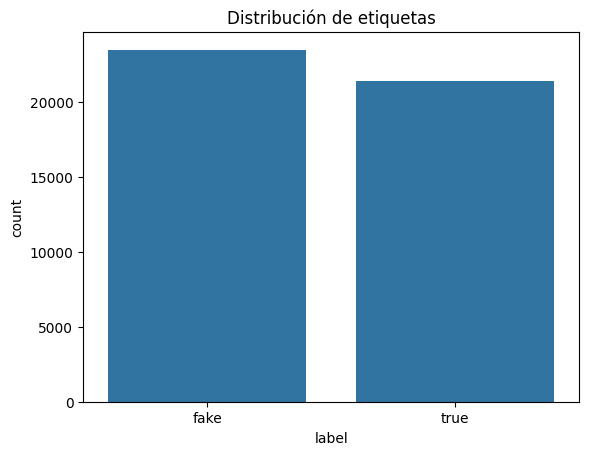

In [ ]:
sns.countplot(data=df, x='label')
plt.title("Distribución de etiquetas")
plt.show()

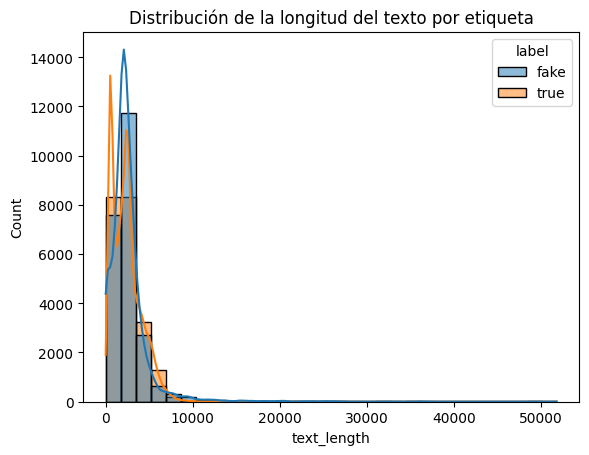

In [ ]:
df['text_length'] = df['text'].apply(len)

sns.histplot(data=df, x='text_length', hue='label', kde=True, bins=30)
plt.title("Distribución de la longitud del texto por etiqueta")
plt.show()


La gráfica ayuda a visualizar si hay diferencias significativas en la longitud de los textos según las etiquetas. En este caso no parece haber una diferencia muy marcada entre textos etiquetados como fake y true en términos de longitud y la mayoría de los textos tienen una longitud dentro de un rango pequeño (cerca del pico principal).

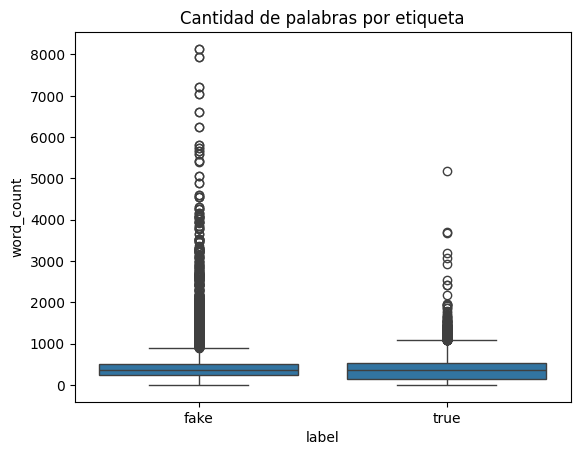

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

sns.boxplot(data=df, x='label', y='word_count')
plt.title("Cantidad de palabras por etiqueta")
plt.show()

Los textos etiquetados como fake tienden a ser más largos (en términos de cantidad de palabras) que los etiquetados como true. Esto se refleja en los valores atípicos más frecuentes y extremos en la categoría fake. La similitud en la mediana de ambas etiquetas indica que, para la mayoría de los casos, la longitud de los textos es comparable entre fake y true.

In [ ]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# contar palabras
def most_common_words(text, n=20):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    return Counter(words).most_common(n)

text = ' '.join(df['text'])
print("Palabras más comunes en noticias:")
print(most_common_words(text))


AttributeError: partially initialized module 'nltk' has no attribute 'data' (most likely due to a circular import)

### 4. Preparar los datos

In [ ]:
df = df[['text', 'label']]
df['label'] = df['label'].map({'fake': 0, 'true': 1})

def preprocess_text(text):
    #  minúsculas
    text = text.lower()
    # caracteres especiales
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # múltiples espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(preprocess_text)
df.head()

,text,label
0,21st century wire says ben stein reputable pro...,0
1,washington reuters us president donald trump r...,1
2,reuters puerto rico governor ricardo rossello ...,1
3,on monday donald trump once again embarrassed ...,0
4,glasgow scotland reuters most us presidential ...,1


### 5. Dividir los datos

In [ ]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")


Tamaño del conjunto de entrenamiento: 35918
Tamaño del conjunto de prueba: 8980


In [ ]:
print("Distribución de etiquetas en el dataset original:")
print(y.value_counts(normalize=True))
print(y.value_counts())

print("\nDistribución de etiquetas en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print("\nDistribución de etiquetas en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Distribución de etiquetas en el dataset original:
label
0    0.522985
1    0.477015
Name: proportion, dtype: float64
label
0    23481
1    21417
Name: count, dtype: int64

Distribución de etiquetas en el conjunto de entrenamiento:
label
0    0.522997
1    0.477003
Name: proportion, dtype: float64
label
0    18785
1    17133
Name: count, dtype: int64

Distribución de etiquetas en el conjunto de prueba:
label
0    0.52294
1    0.47706
Name: proportion, dtype: float64
label
0    4696
1    4284
Name: count, dtype: int64


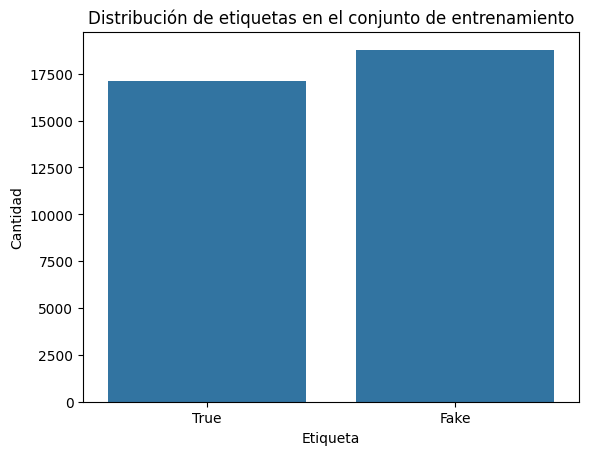

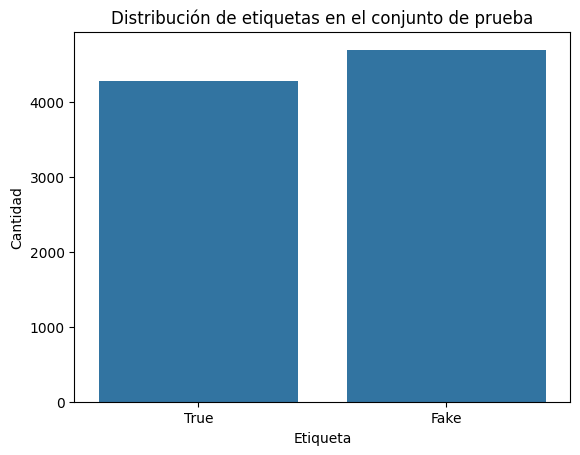

In [ ]:
label_mapping = {0: "Fake", 1: "True"}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

sns.countplot(x=y_train_mapped)
plt.title("Distribución de etiquetas en el conjunto de entrenamiento")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad")
plt.show()

sns.countplot(x=y_test_mapped)
plt.title("Distribución de etiquetas en el conjunto de prueba")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad")
plt.show()

Proporciones en cada conjunto:

| **Conjunto**         | **Clase 0 (Fake)** | **Clase 1 (True)** | **Relación Fake/True** |
|-----------------------|--------------------|--------------------|------------------------|
| **Original**          | 52.30%            | 47.70%            | ~1.10                 |
| **Entrenamiento**     | 52.30%            | 47.70%            | ~1.10                 |
| **Prueba**            | 52.29%            | 47.71%            | ~1.10                 |

Aunque las clases no tienen exactamente la misma cantidad de ejemplos, la diferencia (~4.6%) es lo suficientemente pequeña para que las etiquetas se consideren balanceadas en términos prácticos.

### 6. ALGORITMOS

El vectorizador usado a continuacion genera una representación BoW estándar, donde cada palabra del vocabulario es representada como una característica (columna) en una matriz de características. El valor en cada celda es el número de veces que aparece la palabra en el documento correspondiente.

In [ ]:
# Bag-of-Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

#### 6.1 Regresión Logística con Bag-of-Words

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train_bow, y_train)

y_pred_lr = lr_model.predict(X_test_bow)
print("Accuracy - Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy - Logistic Regression: 0.9973273942093541
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



Cada palabra única del vocabulario tiene un peso (𝑤) asociado.
Además, hay un término de sesgo (𝑏) que se incluye como un parámetro adicional.

Numero de Terminos = Tamaño del vocabulario (n palabras unicas en BoW) + b


In [ ]:
num_terms = X_train_bow.shape[1] # (vocabulary size)

bias = lr_model.intercept_[0]

print(f"Número de términos del modelo de Regresión Logística: {num_terms}")
print(f"Sesgo (bias) del modelo de Regresión Logística: {bias}")
print(f"Terminos: {lr_model.coef_.shape[1]}")


Número de términos del modelo de Regresión Logística: 203677
Sesgo (bias) del modelo de Regresión Logística: -4.9725552020838775
Terminos: 203677


In [ ]:
print("\nParámetros adicionales:")
print(f"Clases del modelo: {lr_model.classes_}")
print(f"Iteraciones realizadas durante el entrenamiento: {lr_model.n_iter_}")
print(f"Valor del parámetro de regularización: {lr_model.C}") # 1/lambda
print(f"Tipo de regularización usado: {lr_model.penalty}")


Parámetros adicionales:
Clases del modelo: [0 1]
Iteraciones realizadas durante el entrenamiento: [92]
Valor del parámetro de regularización: 1.0
Tipo de regularización usado: l2


In [ ]:
print(f"Tamaño del vocabulario: {len(vectorizer.vocabulary_)}")

Tamaño del vocabulario: 203677


En este caso es importante verificar si el rendimiento del modelo es realista o si hay señales de overfitting.

Para eso vamos a revisar el desempeño del modelo en el conjunto de entrenamiento. Si la precisión en el conjunto de entrenamiento es casi igual a la precisión en el conjunto de prueba (en este caso cercado a 100%), es una buena señal de que el modelo no está sobreajustando.

In [ ]:
X_test_bow = vectorizer.transform(X_test)

train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_bow))
print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")

test_accuracy = accuracy_score(y_test, lr_model.predict(X_test_bow))
print(f"Accuracy en prueba: {test_accuracy:.4f}")

Accuracy en entrenamiento: 1.0000
Accuracy en prueba: 0.9973


Tambien vamos a usar validación cruzada para evaluar el modelo en diferentes divisiones de los datos. Si los resultados de validación cruzada son consistentes con los de prueba, tambien es indicador de que el modelo está generalizando bien.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_model, vectorizer.transform(X), y, cv=5, scoring='accuracy')
print(f"Accuracy promedio en validación cruzada: {scores.mean():.4f}")


Accuracy promedio en validación cruzada: 0.9970


Los resultados son solidos. La precisión promedio en validación cruzada y del entrenamiento estan en línea con la precisión en el conjunto de prueba, lo que indica que el modelo está aprendiendo patrones útiles en los datos, en lugar de memorizar ejemplos específicos y no hay signos evidentes de sobreajuste.

In [ ]:
feature_names = vectorizer.get_feature_names_out()
coef = lr_model.coef_[0]

# Palabras asociadas con "fake" (etiqueta 0)
top_fake = np.argsort(coef)[:10]
print("Palabras más asociadas con fake:", feature_names[top_fake])

# Palabras asociadas con "true" (etiqueta 1)
top_true = np.argsort(coef)[-10:]
print("Palabras más asociadas con true:", feature_names[top_true])


Palabras más asociadas con fake: ['via' 're' 'just' 'doesn' 'image' 've' 'don' 'america' 'gop' 'even']
Palabras más asociadas con true: ['clintons' 'wednesday' 'thursday' 'saying' 'im' 'dont' 'washington'
 'said' 'trumps' 'reuters']


In [ ]:
# Guardamos las metricas para compararlas al final
lr_accuracy = accuracy_score(y_test, y_pred_lr) # <- accuracy
lr_classification_report = classification_report(y_test, y_pred_lr) # <- report
lr_conf_matrix = confusion_matrix(y_test, y_pred_lr) # <- confusion matrix

#### 6.2 Naive Bayes con Bag-of-Words

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)

y_pred_nb = nb_model.predict(X_test_bow)
print("Accuracy - Naive Bayes:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Accuracy - Naive Bayes: 0.9650334075723831
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4696
           1       0.95      0.97      0.96      4284

    accuracy                           0.97      8980
   macro avg       0.96      0.97      0.96      8980
weighted avg       0.97      0.97      0.97      8980



In [ ]:
# Cada palabra en el vocabulario tiene asociado un conteo de veces que aparece en los textos de la clase 'fake' y otro en los textos de la clase 'true'. Esto son los `feature_count`.
# Además, hay un conteo total de palabras por clase: `class_count`.
# Y un valor de suavizado `alpha` (por defecto 1.0).

print("Parámetros del modelo Naive Bayes:")
print(f"Conteo de características (palabras): {nb_model.feature_count_.shape}")
print(f"Conteo total de cada clase: {nb_model.class_count_}")
print(f"Valor de suavizado (alpha): {nb_model.alpha}")
print(f"Numero de clases: {nb_model.classes_}")
print(f"Tamaño del vocabulario: {len(vectorizer.vocabulary_)}")



Parámetros del modelo Naive Bayes:
Conteo de características (palabras): (2, 203677)
Conteo total de cada clase: [18785. 17133.]
Valor de suavizado (alpha): 1.0
Numero de clases: [0 1]
Tamaño del vocabulario: 203677


In [ ]:
# Guardamos las metricas para compararlas al final
nb_accuracy = accuracy_score(y_test, y_pred_nb) # <- accuracy
nb_classification_report = classification_report(y_test, y_pred_nb) # <- report
nb_conf_matrix = confusion_matrix(y_test, y_pred_nb) # <- confusion matrix

#### 6.3 K-Nearest Neighbors con Bag-of-Words

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_bow, y_train)

y_pred_knn = knn_model.predict(X_test_bow)
print("Accuracy - KNN:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Accuracy - KNN: 0.8983296213808464
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4696
           1       0.88      0.91      0.90      4284

    accuracy                           0.90      8980
   macro avg       0.90      0.90      0.90      8980
weighted avg       0.90      0.90      0.90      8980



In [ ]:
print("Parámetros del modelo KNN:")
print(f"Número de vecinos: {knn_model.n_neighbors}")
print(f"Algoritmo utilizado para calcular los vecinos: {knn_model.algorithm}")
print(f"Métrica utilizada para la distancia: {knn_model.metric}")
print(f"Pesos asignados a cada vecino: {knn_model.weights}")
print(f"Hoja: {knn_model.leaf_size}")
print(f"Número de trabajos: {knn_model.n_jobs}")
print(f"Tamaño del conjunto de entrenamiento: {X_train_bow.shape[0]}")
print(f"Número de features (palabras): {X_train_bow.shape[1]}")

Parámetros del modelo KNN:
Número de vecinos: 5
Algoritmo utilizado para calcular los vecinos: auto
Métrica utilizada para la distancia: minkowski
Pesos asignados a cada vecino: uniform
Hoja: 30
Número de trabajos: None
Tamaño del conjunto de entrenamiento: 35918
Número de features (palabras): 203677


In [ ]:
# Guardamos las metricas para compararlas al final
knn_accuracy = accuracy_score(y_test, y_pred_knn) # <- accuracy
knn_classification_report = classification_report(y_test, y_pred_knn) # <- report
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn) # <- confusion matrix

#### 6.4 Transformers

In [ ]:
# máximo de palabras que se utilizara
vocab_size = 20000

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])

# convertir textos en secuencias de enteros
sequences = tokenizer.texts_to_sequences(df['text'])

# algunas de las secuencias generadas
print(sequences[:5])

[[966, 740, 957, 191, 1862, 3295, 1508, 25, 485, 61, 3, 81, 1456, 7055, 4004, 6, 1016, 801, 5, 7056, 165, 18, 9, 200, 223, 126, 81, 5569, 1184, 8, 480, 9516, 10447, 9, 238, 682, 112, 2427, 1, 2926, 7, 17, 2186, 8, 37, 16, 9, 366, 245, 8, 824, 3295, 2244, 2, 1, 9894, 20, 1, 4973, 2382, 137, 6, 106, 60, 18, 4, 2026, 613, 89, 1, 366, 2969, 5, 89, 1, 970, 3295, 358, 8, 2, 313, 1, 1715, 6, 3990, 123, 13188, 5, 1, 1724, 123, 505, 1, 294, 891, 10, 1, 1303, 1184, 5, 1656, 1, 6073, 2828, 2, 1, 1234, 3, 1, 1697, 122, 5, 5969, 29, 11349, 2, 1656, 7, 65, 137, 21, 413, 1826, 94, 140, 1845, 6, 316, 6, 1, 372, 47, 1014, 1, 385, 3, 1, 2926, 47, 1, 1798, 2829, 3, 1, 366, 48, 16, 96, 27, 966, 740, 957, 16, 3118, 69, 201, 20, 5188, 1365, 4, 397, 2519], [106, 66, 32, 37, 68, 16, 1577, 19, 327, 2661, 1470, 1521, 25, 1, 124, 120, 544, 8, 196, 7408, 19, 1484, 284, 527, 26, 110, 2, 381, 4, 123, 834, 30, 2357, 532, 6, 120, 2164, 163, 2341, 3, 1, 10882, 799, 20, 4, 87, 71, 222, 61, 9083, 229, 2794, 8515, 585, 3

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(sequences, df['label'], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")
print(len(X_test), "Test sequences")

26938 Training sequences
8980 Validation sequences
8980 Test sequences


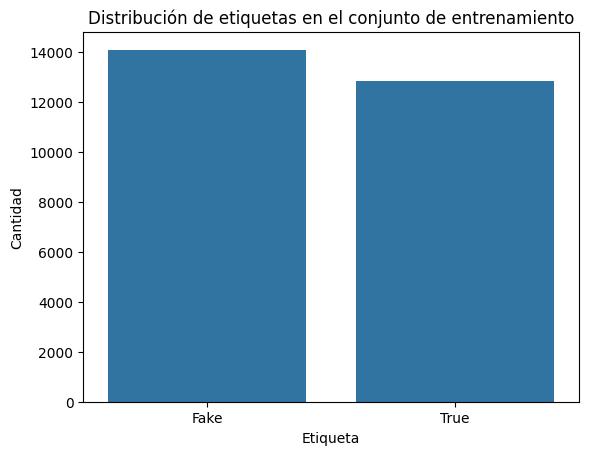

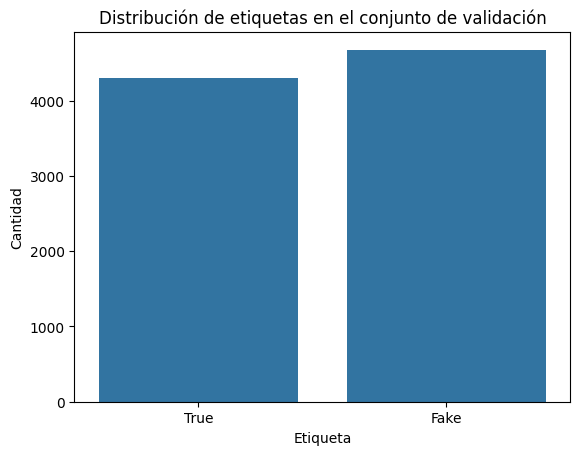

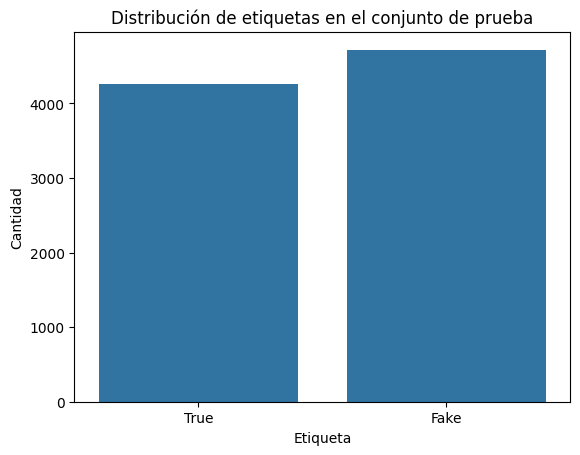

In [ ]:
y_train_mapped = y_train.map(label_mapping)
y_val_mapped = y_val.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

sns.countplot(x=y_train_mapped)
plt.title("Distribución de etiquetas en el conjunto de entrenamiento")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad")
plt.show()

sns.countplot(x=y_val_mapped)
plt.title("Distribución de etiquetas en el conjunto de validación")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad")
plt.show()

sns.countplot(x=y_test_mapped)
plt.title("Distribución de etiquetas en el conjunto de prueba")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad")
plt.show()


In [ ]:
# longitud máxima de las secuencias
maxlen = 200

# rellenar secuencias para que todas tengan la misma longitud
x_train = pad_sequences(X_train, maxlen=maxlen)
x_val = pad_sequences(X_val, maxlen=maxlen)
x_test = pad_sequences(X_test, maxlen=maxlen)

print(x_train.shape, x_val.shape, x_test.shape )


(26938, 200) (8980, 200) (8980, 200)


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 111s 126ms/step - accuracy: 0.8602 - loss: 0.2873 - val_accuracy: 0.9798 - val_loss: 0.0601
Epoch 2/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 140s 124ms/step - accuracy: 0.9923 - loss: 0.0356 - val_accuracy: 0.9911 - val_loss: 0.0307
Epoch 3/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 140s 122ms/step - accuracy: 0.9977 - loss: 0.0136 - val_accuracy: 0.9888 - val_loss: 0.0342
Epoch 4/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 143s 123ms/step - accuracy: 0.9982 - loss: 0.0101 - val_accuracy: 0.9884 - val_loss: 0.0418
Epoch 5/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 103s 122ms/step - accuracy: 0.9990 - loss: 0.0071 - val_accuracy: 0.9846 - val_loss: 0.0638
Epoch 6/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 158s 142ms/step - accuracy: 0.9988 - loss: 0.0067 - val_accuracy: 0.9898 - val_loss: 0.0700
Epoch 7/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 129s 127ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9893 - val_loss: 0.0655
Epoch 8/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 140s 124ms/step - accuracy: 0.9988 -

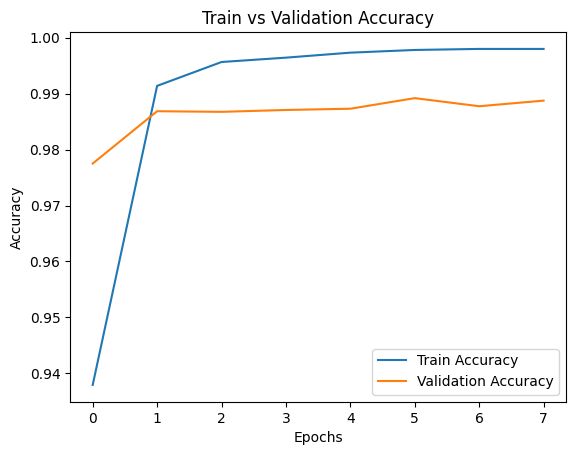

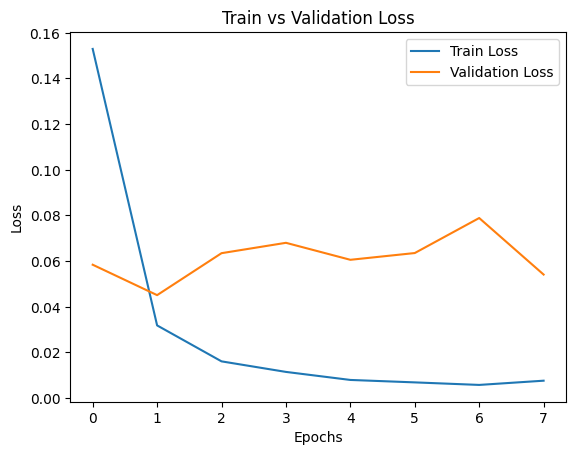

In [ ]:
import matplotlib.pyplot as plt

# Graficar accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

# Graficar loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9885 - loss: 0.0537
Test Loss: 0.04546774551272392
Test Accuracy: 0.9888641238212585


In [ ]:
# Guardamos las metricas para compararlas al final
t_accuracy = test_accuracy # <- accuracy
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)
t_conf_matrix = confusion_matrix(y_test, y_pred_classes)

281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step


### 7. Comparaciones

Resultados Comparativos:
                Modelo  Accuracy
0  Logistic Regression  0.997327
1          Naive Bayes  0.965033
2                  KNN  0.898330
3         Transformers  0.988864


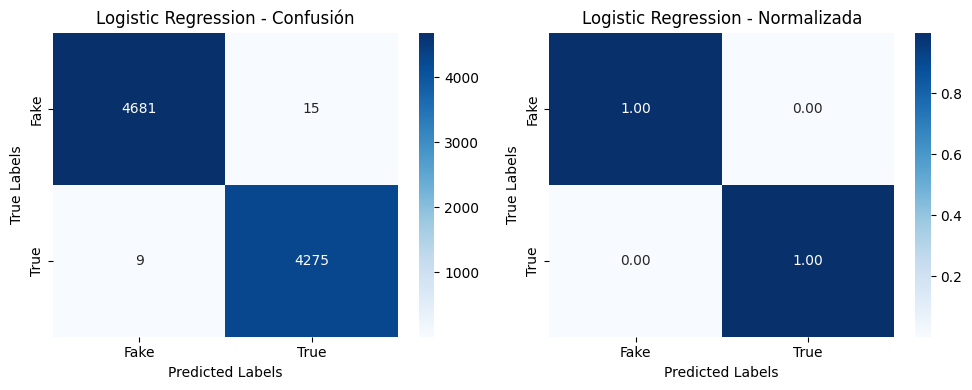

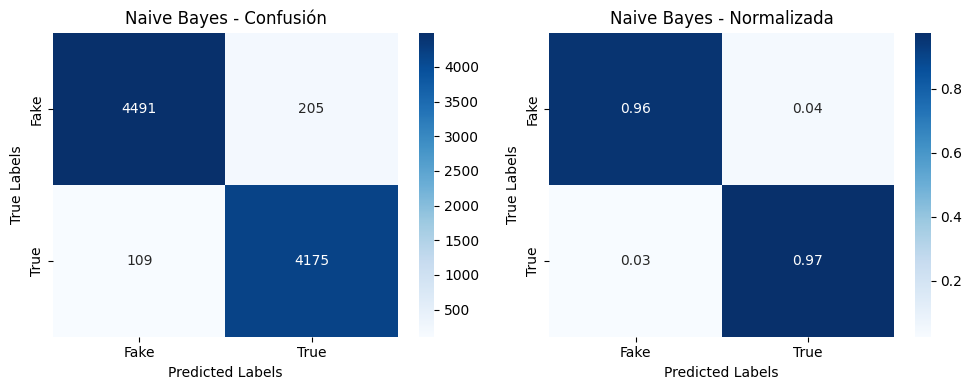

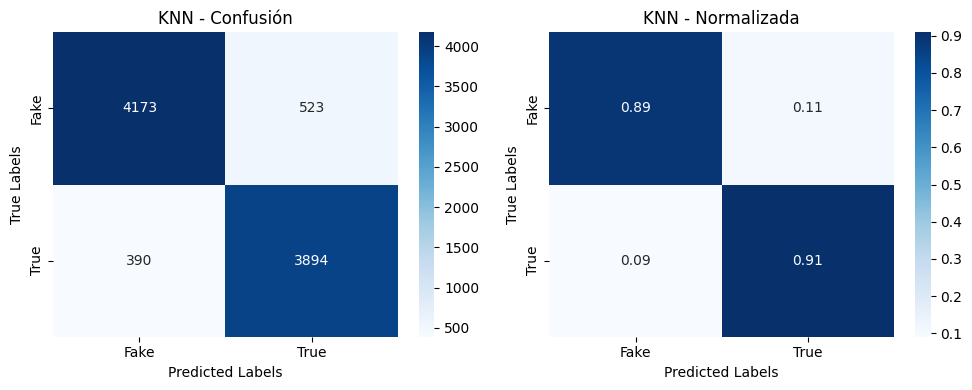

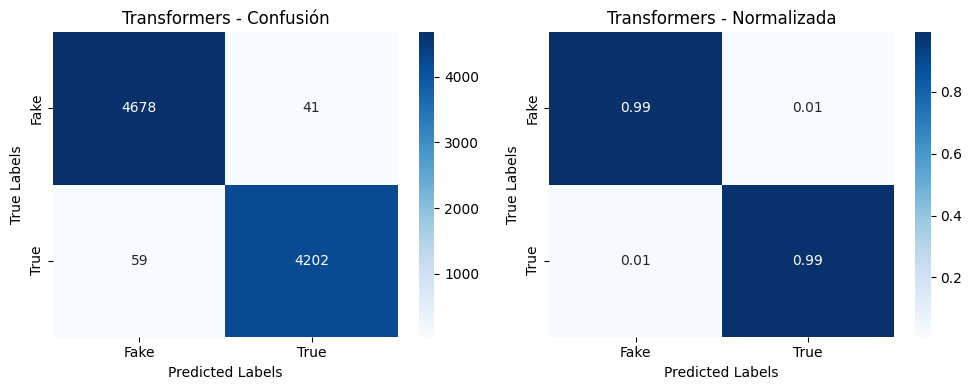

In [ ]:
def plot_confusion_matrix(model_name, cm):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'], ax=axes[0])
    axes[0].set_title(f"{model_name} - Confusión")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'], ax=axes[1])
    axes[1].set_title(f"{model_name} - Normalizada")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    plt.tight_layout()
    plt.show()

# cuadro comparativo
def evaluate_model(model_name,accuracy):
    return {
        'Modelo': model_name,
        'Accuracy': accuracy,
    }

results = []
results.append(evaluate_model('Logistic Regression', lr_accuracy))
results.append(evaluate_model('Naive Bayes', nb_accuracy))
results.append(evaluate_model('KNN', knn_accuracy))
results.append(evaluate_model('Transformers', t_accuracy))

# dataFrame para comparación
results_df = pd.DataFrame(results)
print("Resultados Comparativos:")
print(results_df)

plot_confusion_matrix('Logistic Regression', lr_conf_matrix)
plot_confusion_matrix('Naive Bayes', nb_conf_matrix)
plot_confusion_matrix('KNN', knn_conf_matrix)
plot_confusion_matrix('Transformers', t_conf_matrix)

### 8. Concluciones

* El modelo de *Logistic Regression* obtuvo la mayor accuracy (99.73%) entre los cuatro modelos evaluados, mostrando capacidad para clasificar correctamente las noticias como verdaderas o falsas.
* El modelo basados en *Transformers* también tuvo un rendimiento sobresaliente con una accuracy del 98.85%. Aunque el rendimiento es ligeramente inferior al de *Logistic Regression*, sigue siendo competitivo y podría ser preferible en aplicaciones que requieren capacidades avanzadas.
* Con un accuracy del 96.50%, *Naive Bayes* muestra un rendimiento decente, pero considerablemente menor en comparación con los mencionados anteriormente
* El modelo de *KNN* tuvo el peor rendimiento. Los errores son significativos, con 523 falsos positivos y 390 falsos negativos. Esto indica que este enfoque no es tan efectivo para este conjunto de datos.

El modelo lineal *Logistic Regression* es efectivo y simple para este conjunto de datos debido a la buena separación de las características, mientras que Transformers ofrece mayor robustez a costa de un mayor costo computacional, siendo más adecuado para problemas complejos. En contraste, Naive Bayes y KNN presentan limitaciones significativas para el problema.